<a href="https://colab.research.google.com/github/iamviji/project/blob/master/Final/Experiment/Keras_BLER_COST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy
import time


from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras import Model
from keras.layers.normalization import BatchNormalization
import tensorflow as tf

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior ()

input_message_length = 10
encoder_output_length = 30
channel_size = 10
NUM_OF_INPUT_MESSAGE = 10000
SNR_STEP_SIZE = .5

SNR_BEGIN = 0
SNR_END = 10

bler_per_iter_uncoded_commpy_psk_2= [0.521, 0.473, 0.436, 0.37,  0.304, 0.259, 0.187, 0.138, 0.098, 0.098, 0.052, 0.028, 0.012, 0.011, 0.009, 0.002, 0.0,  0.001, 0.,    0.0]
bler_per_iter_uncoded_itpp_psk_2= [0.518, 0.478, 0.415, 0.355, 0.305, 0.227, 0.177, 0.149, 0.11,  0.075, 0.055, 0.023, 0.014, 0.014, 0.015, 0.001, 0.003, 0.001, 0.,    0. ]
bler_per_iter_uncoded_commpy_psk_4 = [0.815, 0.793, 0.75,  0.714, 0.64,  0.639, 0.526, 0.49,  0.433, 0.371, 0.335, 0.236, 0.204, 0.154, 0.129, 0.08,  0.063, 0.046, 0.023, 0.018]
bler_per_iter_uncoded_itpp_psk_4 = [0.814, 0.767, 0.729, 0.702, 0.66,  0.616, 0.563, 0.511, 0.442, 0.4,   0.294, 0.277, 0.228, 0.17,  0.114, 0.087, 0.05,  0.037, 0.022, 0.017]
bler_per_iter_ldpc_itpp_psk_4 = [0.584, 0.488, 0.404, 0.332, 0.218, 0.151, 0.097, 0.058, 0.041, 0.024, 0.007, 0.004, 0.002, 0.001, 0.001, 0.,    0.,    0.,    0.,    0.,   ]
bler_per_iter_ham_itpp_psk_4= [0.51, 0.479, 0.419, 0.333, 0.313, 0.247, 0.212, 0.132, 0.114, 0.093, 0.042, 0.027, 0.024, 0.016, 0.006, 0.005, 0.003, 0.002, 0.,    0.  ]
bler_per_iter_ldpc_50_100_itpp_psk_4 = [1., 1., 0.997, 0.989, 0.92,  0.697, 0.391, 0.123, 0.042, 0.011, 0.,    0.,  0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]


def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma


def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff


In [50]:

from keras import backend as K

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


#decoder_input_x = tf.placeholder("float32", [None, input_message_length], name="decoder_input_x")

snr_std = -100

def my_loss(y_true, y_pred):
  #tf.reduce_mean (-1 * (y_true*tf.log(y_pred) + (1 - y_true)*tf.log(1 - y_pred) ))
  tf.reduce_mean ((tf.reduce_sum(tf.square(y_true-y_pred), axis=1)))

def custom_loss_function(y_true, y_pred):
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=-1)

def _loss_tensor(y_true, y_pred):
    print (y_true)
    #y_true_x = tf.cast(y_true, dtype=tf.float32)
    #y_pred_x = tf.cast(y_pred, dtype=tf.float32)
    #out = -(y_true_x * K.log(y_pred_x) + (1.0 - y_true_x) * K.log(1.0 - y_pred_x))
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer1 = Dense(encoder_output_length, activation='tanh')(input_message_x)
enc_layer2 = Dense(2*channel_size, activation='tanh')(enc_layer1)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(2*channel_size,))
dec_layer1 = Dense(encoder_output_length, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation="sigmoid")(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

#decoder_output = (tf.nn.sigmoid(decoder_input_x))

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           330         input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 20)           620         dense_4[0][0]                    
__________________________________________________________________________________________________
tf.math.square_1 (TFOpLambda)   (None, 20)           0           dense_5[0][0]                    
___________________________________________________________________________________________

In [3]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message = tf.cast(training_input_message, dtype=tf.float32)
#training_input_message_label = training_input_message.reshape(,1)
#training_input_message_label = []
#= training_input_message.reshape(training_input_message.shape[NUM_OF_INPUT_MESSAGE*10])
#for i in range (NUM_OF_INPUT_MESSAGE*10):
#  training_input_message_label.append (training_input_message[i][0])
print (training_input_message)
print (len(training_input_message))
print ('x')
#print (training_input_message_label)
print(input_message_length)

tf.Tensor(
[[1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 ...
 [0. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 [0. 1. 1. ... 0. 1. 0.]], shape=(100000, 10), dtype=float32)
100000
x
10


In [4]:
test_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
test_input_message = tf.cast(test_input_message, dtype=tf.float32)
test_input_message_label = []
for i in range (NUM_OF_INPUT_MESSAGE*10):
  test_input_message_label.append (test_input_message[i][0])
print (test_input_message)
print (len(test_input_message))

tf.Tensor(
[[1. 1. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 1. 1. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 1. 0.]], shape=(100000, 10), dtype=float32)
100000


In [72]:
import keras
#from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras import applications

import tensorflow as tf

def custom_losff_fucntion_bler1 (input_message_binary1, input_message_binary2):
  #  diff = abs(input_message_binary1 - tf.round(input_message_binary2))
  diff = (input_message_binary1 - (input_message_binary2))
  return tf.reduce_mean(input_message_binary1*input_message_binary2)

  field_sum = tf.reduce_sum (diff, axis=1)
  field_sum = tf.reshape (field_sum, (-1,1))
  #ber = numpy.sum(field_sum)/(input_message_binary1.shape[0]*input_message_binary1.shape[1])
  field_non_zero_count = tf.math.count_nonzero(field_sum != 0, axis=1)
  bler = tf.reduce_sum(field_non_zero_count)/field_non_zero_count.shape[0]
  print ("xxx")
  print (bler)
  return  bler

def custom_losff_fucntion_bce (target, predicted):
    return (tf.reduce_mean(-1*(target * tf.math.log(predicted) + (1-target)*tf.math.log(1-predicted))))

def custom_losff_fucntion_bler (target, predicted):
  print ("xxx")
  diff1 = (abs((predicted)-target))
  print (diff1)
  diff2 = tf.reshape(diff1, [target.shape[0],target.shape[1]]) 
  print (diff2)
  print (target.shape[0])
  print ("XXXXXX")
  #bler = tf.reduce_sum(tf.reduce_sum(diff2,axis=1)>0)*1.0/(target.shape[0])
  bler = tf.reduce_sum(tf.reduce_sum(diff2,axis=1)>0)*1.0/(target.shape[0])
  print ("XXXXXX",bler)
  print (bler)
  return bler

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss=[tf.keras.losses.sparse_categorical_crossentropy],metrics=['accuracy'])
  #autoencoder.compile(optimizer=opt, loss='mse',metrics=['accuracy'])
  autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion_bler1,metrics=['accuracy'])
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=20,
                batch_size=5000,
                shuffle=False)#,
                #validation_data=(test_input_message_label, test_input_message_label))

Training for SNR= 0.0  sigma= 1.0
Epoch 1/20
20/20 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.5001
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.5001
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.5001
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.5001
Epoch 5/20
20/20 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.5001
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.5001
Epoch 7/20
20/20 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.5001
Epoch 8/20
20/20 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.5001
Epoch 9/20
20/20 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.5001
Epoch 10/20
20/20 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.5001
Epoch 11/2

KeyboardInterrupt: ignored

In [25]:
def GetBerBler (input_message_binary1, input_message_binary2):
  diff = abs(input_message_binary1 - input_message_binary2)
  field_sum = numpy.sum (diff, axis=1)
  field_sum = numpy.reshape (field_sum, (-1,1))
  ber = numpy.sum(field_sum)/(input_message_binary1.shape[0]*input_message_binary1.shape[1])
  field_non_zero_count = numpy.count_nonzero(field_sum != 0, axis=1)
  bler = numpy.sum(field_non_zero_count)/field_non_zero_count.shape[0]
  return ber, bler

def get_ber_bler_of_model (snr_list, encoder, decoder, input_binary, num_of_input_msg, input_message_length, channel_size, verbose=1):
  bler_per_iter_dl_tensor  = numpy.array(())
  ber_per_iter_dl_tensor  = numpy.array(())
  channel_out = []
  encoded_message = encoder.predict(input_binary)
  for snr in snr_list:
    total_bit_error = 0
    total_msg_error = 0    
    sigma = Snr2Sigma (snr)
    noised_message = encoded_message + numpy.random.normal(0, sigma, encoded_message.shape)
    for i in range (num_of_input_msg):
      noised_message[i] = encoded_message[i] + numpy.random.normal(0, sigma, [1,2*channel_size])
      channel_out.append(noised_message[i])
    decoded_message = decoder.predict(noised_message)
    decoded_message = numpy.around(decoded_message).astype(int)
    ber,bler = GetBerBler (input_binary, decoded_message)
    print('SNR: {:04.3f}:-> BLER: {:03.3f} BER: {:03.3f}'.format(snr,bler,ber))
    bler_per_iter_dl_tensor = numpy.append(bler_per_iter_dl_tensor, bler)
    ber_per_iter_dl_tensor = numpy.append(ber_per_iter_dl_tensor, ber)
  return ber_per_iter_dl_tensor, bler_per_iter_dl_tensor, channel_out

In [26]:
snrs_list = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
ber_per_iter_dl_tensor1, bler_per_iter_dl_tensor1, channel_out1 = get_ber_bler_of_model(snrs_list, encoder, decoder, training_input_message, NUM_OF_INPUT_MESSAGE,input_message_length, channel_size)

SNR: 0.000:-> BLER: 0.564 BER: 0.080
SNR: 0.500:-> BLER: 0.505 BER: 0.068
SNR: 1.000:-> BLER: 0.442 BER: 0.057
SNR: 1.500:-> BLER: 0.382 BER: 0.047
SNR: 2.000:-> BLER: 0.320 BER: 0.038
SNR: 2.500:-> BLER: 0.263 BER: 0.030
SNR: 3.000:-> BLER: 0.210 BER: 0.023
SNR: 3.500:-> BLER: 0.162 BER: 0.017
SNR: 4.000:-> BLER: 0.121 BER: 0.013
SNR: 4.500:-> BLER: 0.087 BER: 0.009
SNR: 5.000:-> BLER: 0.059 BER: 0.006
SNR: 5.500:-> BLER: 0.039 BER: 0.004
SNR: 6.000:-> BLER: 0.024 BER: 0.002
SNR: 6.500:-> BLER: 0.015 BER: 0.001
SNR: 7.000:-> BLER: 0.009 BER: 0.001
SNR: 7.500:-> BLER: 0.005 BER: 0.000
SNR: 8.000:-> BLER: 0.002 BER: 0.000
SNR: 8.500:-> BLER: 0.001 BER: 0.000
SNR: 9.000:-> BLER: 0.000 BER: 0.000
SNR: 9.500:-> BLER: 0.000 BER: 0.000


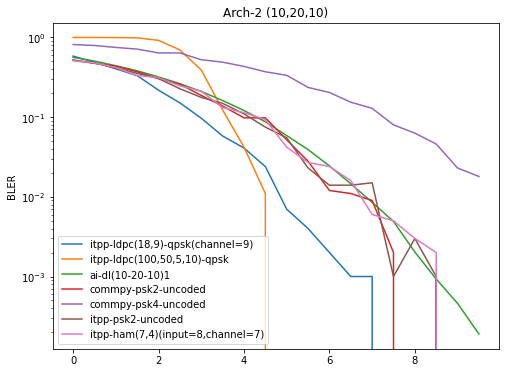

In [29]:
import matplotlib.pyplot as plt
#import numpy
%matplotlib inline
#ber_per_iter_dl_tensor = [.99,.98,.95,.93,.91,.83,.74,.66,.55,.46,.38,.26,.19,.10,.07,.05,.02,0.02,0.01,0.0]
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_50_100_itpp_psk_4,'', label="itpp-ldpc(100,50,5,10)-qpsk") # plot BER vs SNR
#ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(10-20-10)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_dl_tensor1,'', label="ai-dl(10-20-10)1") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

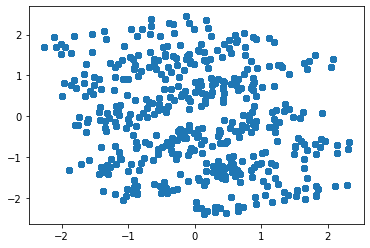

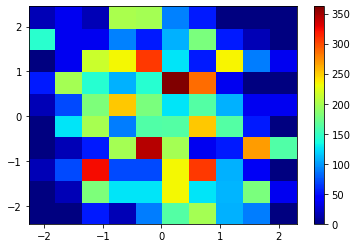

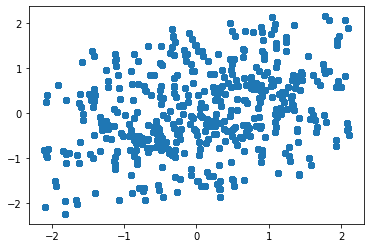

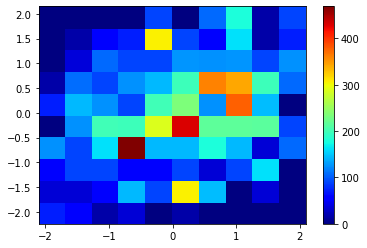

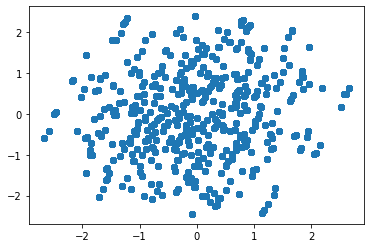

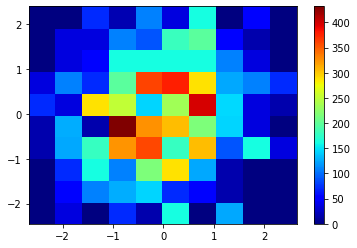

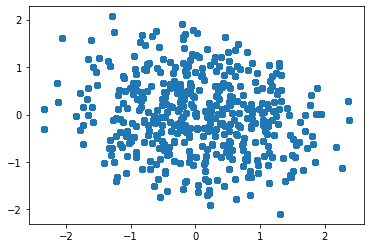

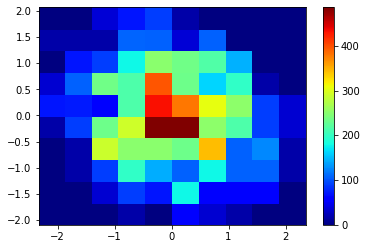

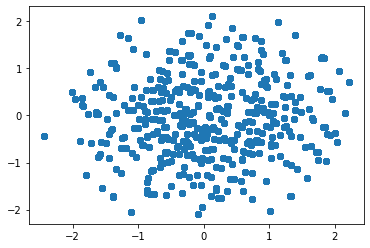

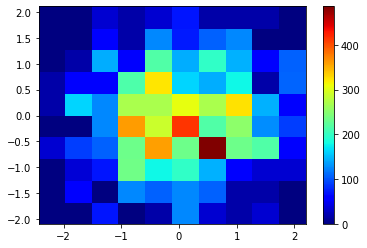

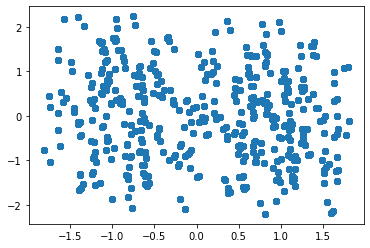

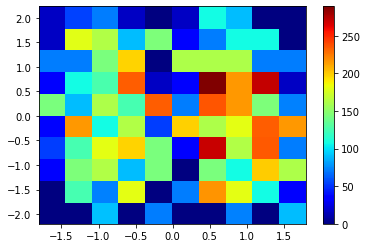

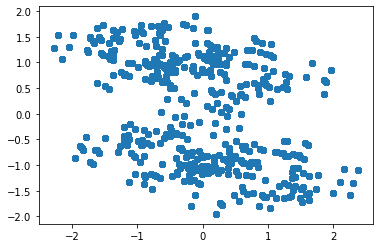

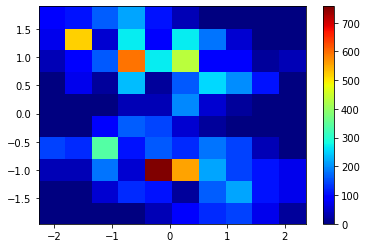

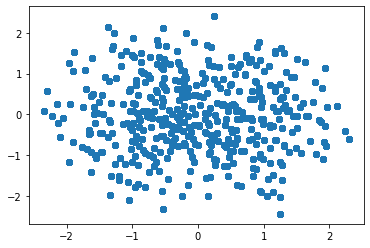

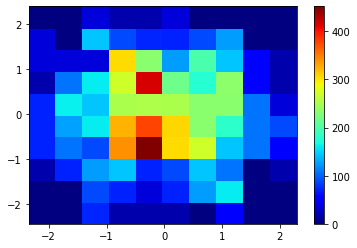

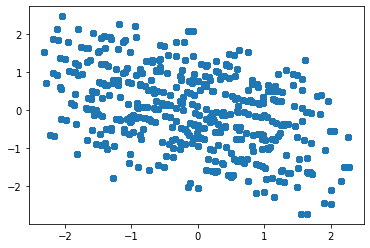

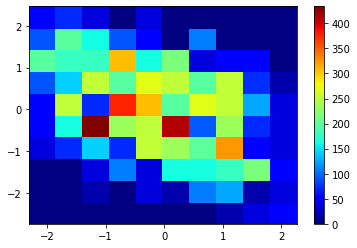

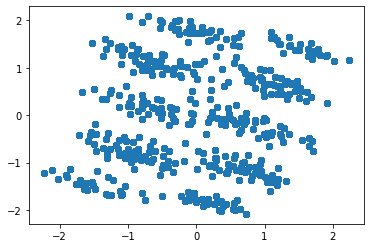

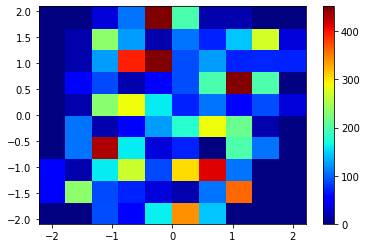

In [30]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

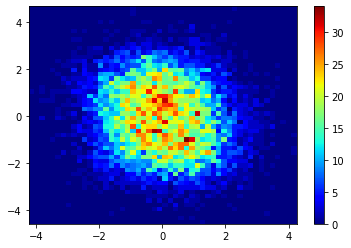

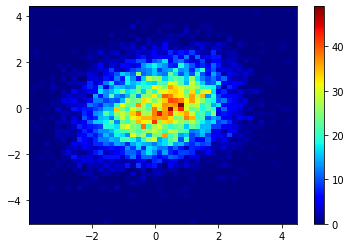

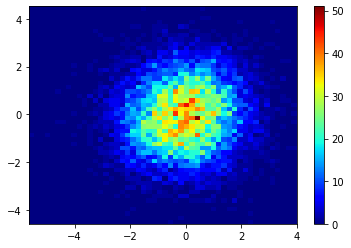

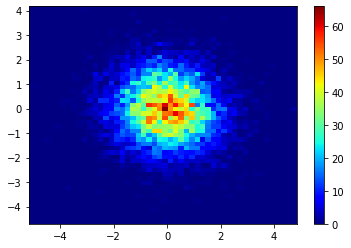

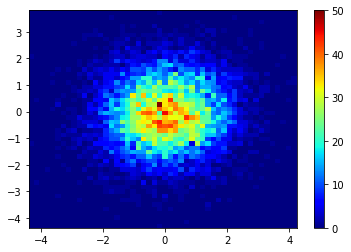

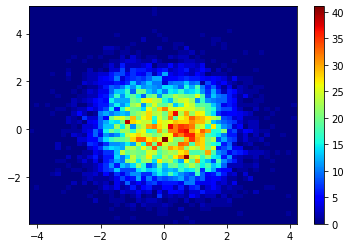

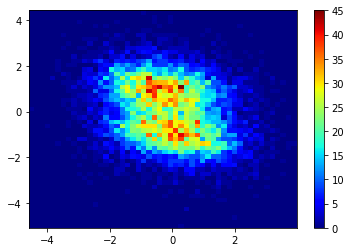

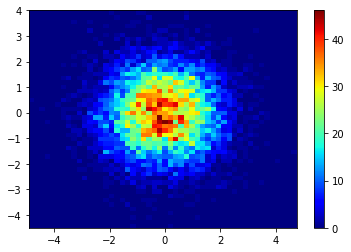

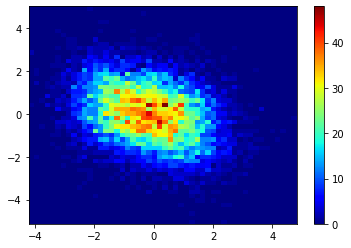

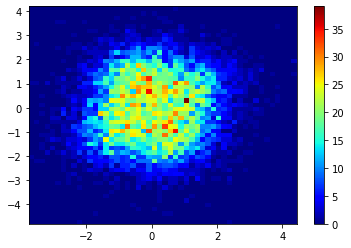

In [31]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

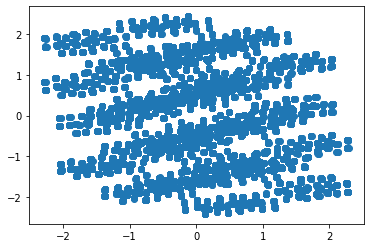

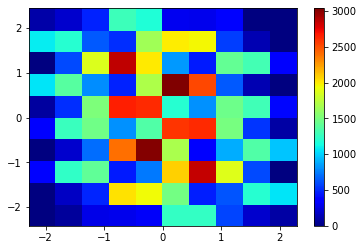

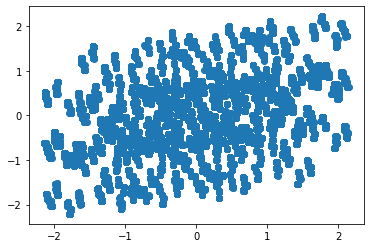

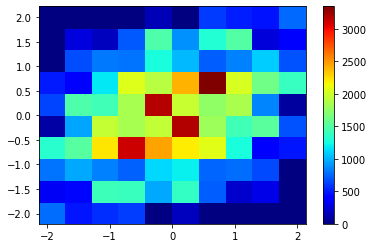

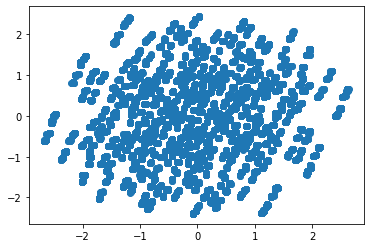

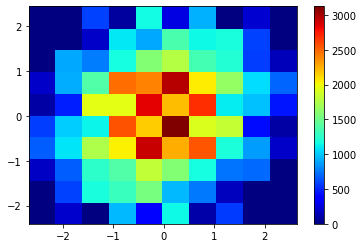

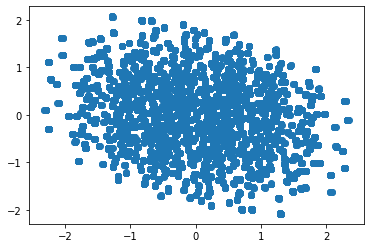

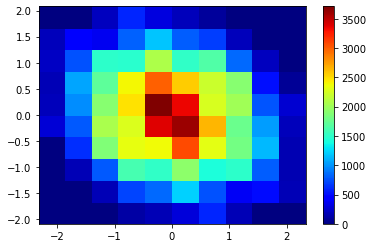

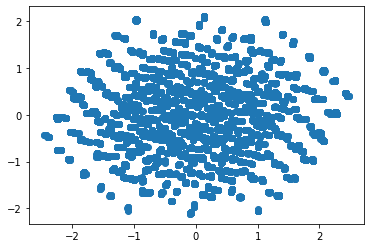

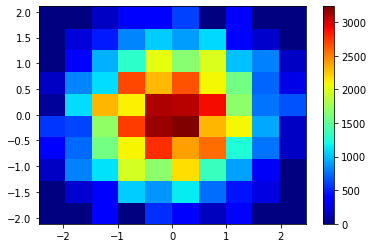

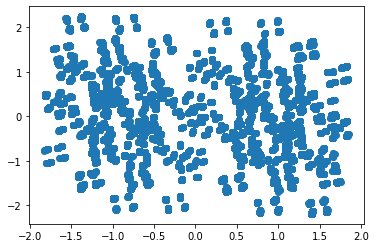

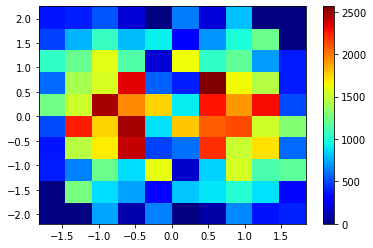

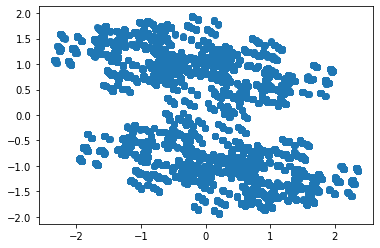

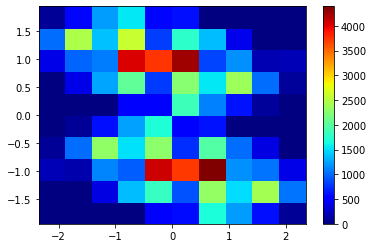

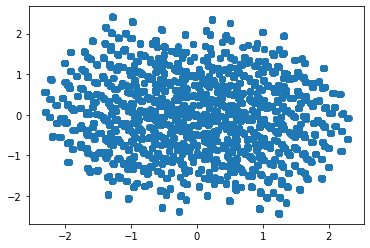

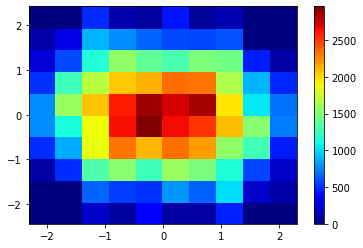

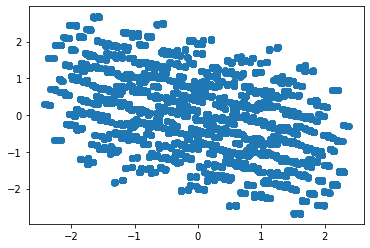

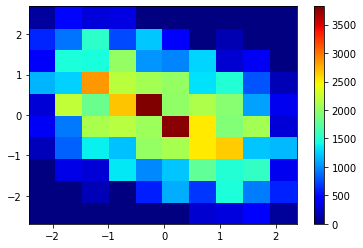

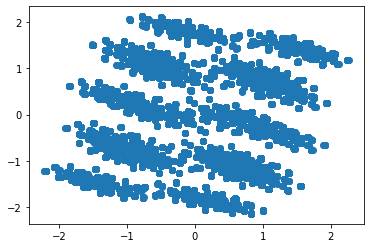

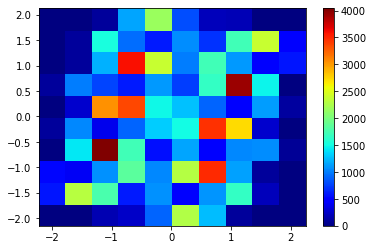

In [33]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(encoder.predict(training_input_message))

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

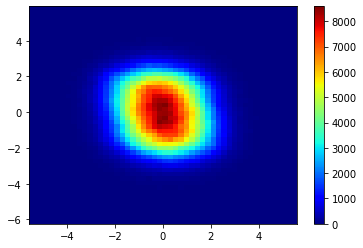

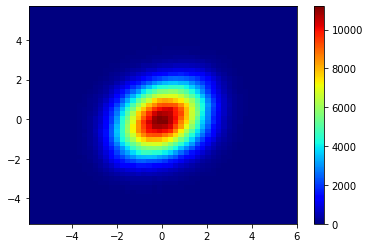

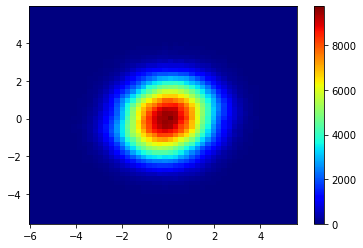

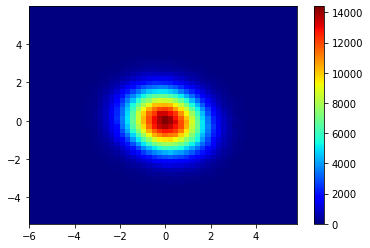

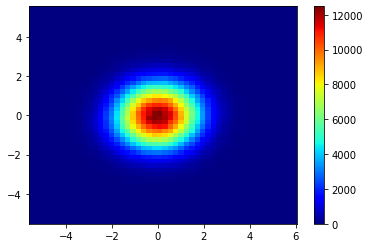

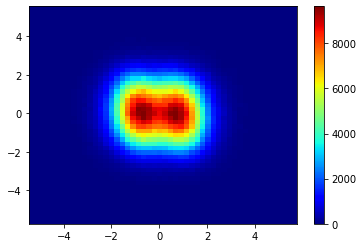

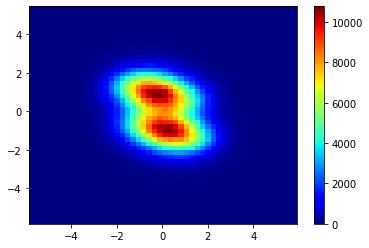

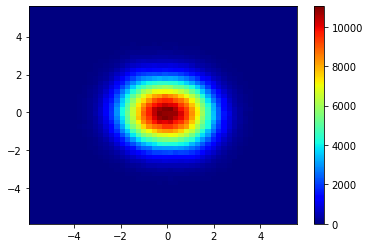

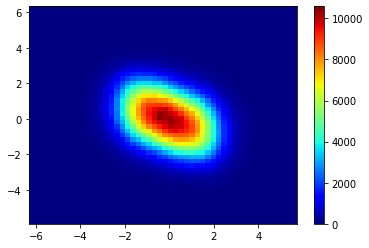

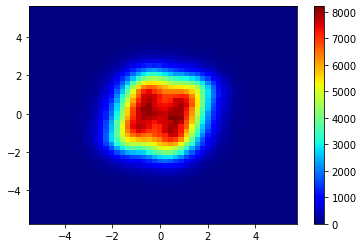

In [32]:
channel_out_array = numpy.transpose(channel_out1)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()